### Resources:
* [D-separation steps](http://web.mit.edu/jmn/www/6.034/d-separation.pdf)
* [bnlearn datasets](https://www.bnlearn.com/bnrepository/)
* [Daggity paper](https://academic.oup.com/ije/article/45/6/1887/2907796)

### TODO:
* Break into module, write proper unit tests
* What about conditional independencies?  Currently only covers independencies.  
   * Can I just enumerate tripples and check 'A,B given=["C"]'?  
   * Would then check combinations-pairs + combinations-givens 
   * Up to how many givens do you check?

In [1]:
import y0
import networkx as nx
import pandas as pd

from collections import abc
from itertools import combinations, chain
%matplotlib inline

In [2]:
edges = [("A","C"), ("B","C"), ("C","D"), ("C","E"), ("D","F"), ("F","G")]
G = nx.DiGraph(edges)

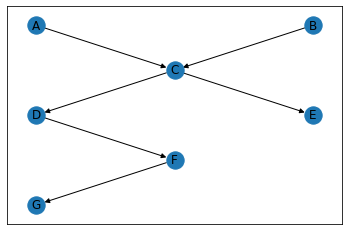

In [3]:
layout = {"A": (0,-1), "B": (2,-1), "C": (1,-2), "D": (0, -3), "E": (2, -3), "F":(1,-4), "G": (0,-5)}
nx.draw_networkx(G, pos=layout)

In [4]:
def are_d_separated(G, a,b, *, given=[]):
    """Tests if nodes named by a & b are d-separated in G.
    Given conditions can be provided with the optional 'given' parameter.
    returns T/F and the final graph (as evidence)
    """
    class Result:
        def __init__(self, separated, G):
            self.separated=separated
            self.G=G
        def __bool__(self): return self.separated
        def __repr__(self): return f"{repr(self.separated)}*"
        def __eq__(self, other): return self.separated == other
    
    named = set([a,b]).union(given)
    
    # Filter to ancestors
    keep = set(chain(*(nx.ancestors(G, n) for n in named))).union(named)
    G = nx.subgraph(G, keep).copy()

    # Moralize (link parents of mentioned nodes)
    in_edges = ([*G.in_edges(n)] for n in G)
    parents = ([*zip(*edges)][0] for edges in in_edges
                if len(edges)>0)
    augments = [*chain(*[combinations(nodes, 2) for nodes in parents])]
    G.add_edges_from(augments)
    
    # disorient & remove givens
    G = G.to_undirected()
    keep = set(G.nodes()) - set(given)
    G = G.subgraph(keep)

    # check for path....
    separated = not nx.has_path(G, a, b)   #If no path, then d-separated!
    
    return Result(separated, G)

In [5]:
#TODO: Convert to unit tests...
all([are_d_separated(G, "A", "B", given=["D", "F"]) == False,
     are_d_separated(G, "A", "B") == True,
     are_d_separated(G, "A", "B", given=["C"]) == False,
     are_d_separated(G, "D", "E", given=["C"]) == True,
     are_d_separated(G, "D", "E") == False,
     are_d_separated(G, "D", "E", given=["A", "B"]) == False,
     are_d_separated(G, "G", "G", given=["C"]) == False])

True

In [6]:
def and_print(iterable, prefix="--"):
    it = iter(iterable)
    while it:
        try: v = next(it)
        except: return
        print(f"{prefix} {v}")
        yield v
def falsifications(G, df, threshold=.5, verbose=False):
    class Evidence(abc.Sequence):
        """A list of variables pairs that failed the d_sepration+covariance test.
        
        Has an extra 'variances' property that is a dictionary of all tests performed
        and the covariances observed between them.
        """
        def __init__(self, failures, evidence):
            self._failures = failures
            self.evidence = evidence
        
        def __getitem__(self, i): return self._failures[i]
        def __len__(self): return len(self._failures)
        def __repr__(self): return repr(self._failures) + "+evidence"
    
    
    if verbose: wrapper=and_print
    else: wrapper=lambda v:v
        
    to_test = [(a,b) for a,b in combinations(G.nodes, 2)
                if are_d_separated(G, a, b)]

    variances = {(a,b): df[a].corr(df[b], method='pearson') 
                 for a,b in wrapper(to_test)}
    #return variances
    failures = [k for k, corr in variances.items()
                if abs(corr) > threshold]
    return Evidence(failures, variances)
    

issues = falsifications(G, pd.DataFrame(columns=G.nodes()))

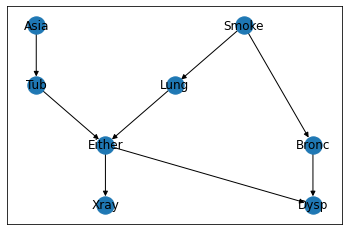

In [7]:
edges = [("Asia", "Tub"), 
         ("Smoke", "Lung"), ("Smoke", "Bronc"),
         ("Tub", "Either"),
         ("Lung", "Either"),
         ("Either", "Xray"), ("Either", "Dysp"),
         ("Bronc", "Dysp")]
layout = {"Asia": (0,0),
          "Smoke": (3,0),
          "Tub": (0, -1),
          "Lung": (2, -1),
          "Either": (1, -2),
          "Bronc": (4, -2),
          "Xray": (1, -3),
          "Dysp": (4, -3)}
asia_G = nx.DiGraph(edges)
asia_df = pd.read_csv("asia.csv", index_col=0)\
            .replace({"yes":1, "no":-1})
nx.draw_networkx(asia_G, pos=layout)

In [8]:
#Should be no issues here...
issues = falsifications(asia_G, asia_df)
issues

[]+evidence

In [9]:
# Should be issues (Lung, Either) AT LEAST.
#.  Seeing issues (Lung, Xray) as well.  Is that all? 
# TODO: Check d-separations by hand...
asia_G2 = asia_G.copy()
asia_G2.remove_edge("Lung", "Either")
issues = falsifications(asia_G2, asia_df)
issues

[('Lung', 'Either'), ('Lung', 'Xray')]+evidence